In [1]:
%load_ext autoreload
%autoreload 2

Please keep this notebook functionally at par with scripts/oncall/generate_report.py AND linearly runnable (no code with duplicated functionality; run all from this cell down should produce a report). Modify the parameters in `single_fitting_cycle` and `plot_trials` per customizations

In [2]:
import numpy as np
import pandas as pd

import datetime
import copy
import json
import time
import os

import sys
sys.path.append('../../')

from data.dataloader import Covid19IndiaLoader
from data.processing import get_data
from data.processing import get_dataframes_cached

from models.seir import SEIR_Testing, SEIRHD, SEIR_Movement, SEIR_Movement_Testing

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, forecast_all_trials, trials_to_df, create_region_csv, write_csv
from utils.create_report import create_report
from utils.enums import Columns
from utils.loss import Loss_Calculator
from viz import plot_forecast, plot_top_k_trials

In [3]:
t = time.time()
output_folder = f'../../reports/{t}'

## Params

In [4]:
ktrials = 10
forecast_days = 45

In [5]:
predictions_dict = {}

## Select Districts to fit on

In [6]:
state, district = ('Maharashtra', 'Mumbai')

## Perform M1 and M2 fits

Performing m1 fit ..
fetching from athenadb...
6191
smoothing length truncated to 47
3139
smoothing length truncated to 64
-891
smoothing length truncated to 65


/Users/sansiddhjain/opt/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2434
smoothing length truncated to 26
2141
smoothing length truncated to 27
2587
smoothing length truncated to 29
5903
smoothing length truncated to 34
2420
smoothing length truncated to 37
917
smoothing length truncated to 65
0     True
1     True
2     True
3     True
4     True
      ... 
84    True
85    True
86    True
87    True
88    True
Length: 89, dtype: bool
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
75 2020-06-27  maharashtra   mumbai         73673.0       20044.0    49359.2   
76 2020-06-28  maharashtra   mumbai         74914.4       20360.8    50185.0   
77 2020-06-29  maharashtra   mumbai         76198.6       20743.2    50996.4   
78 2020-06-30  maharashtra   mumbai         77501.6       21198.6    51763.2   
79 2020-07-01  maharashtra   mumbai         78819.0       21540.4    52660.8   

    deceased  
75    4269.8  
76    4368.6  
77    4459.0  
78    4539.8  
79    4617.8  
val
         d

/Users/sansiddhjain/opt/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


2434
smoothing length truncated to 26
2141
smoothing length truncated to 27
2587
smoothing length truncated to 29
5903
smoothing length truncated to 34
2420
smoothing length truncated to 37
917
smoothing length truncated to 65
0     True
1     True
2     True
3     True
4     True
      ... 
84    True
85    True
86    True
87    True
88    True
Length: 89, dtype: bool
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
82 2020-07-04  maharashtra   mumbai         82832.2       22701.2    55310.4   
83 2020-07-05  maharashtra   mumbai         84006.2       22769.8    56353.2   
84 2020-07-06  maharashtra   mumbai         85182.0       22980.4    57258.0   
85 2020-07-07  maharashtra   mumbai         86132.0       22996.0    58137.0   
86 2020-07-08  maharashtra   mumbai         87513.0       23214.0    59238.0   

    deceased  
82    4820.6  
83    4883.2  
84    4943.6  
85    4999.0  
86    5061.0  
val
 None
100%

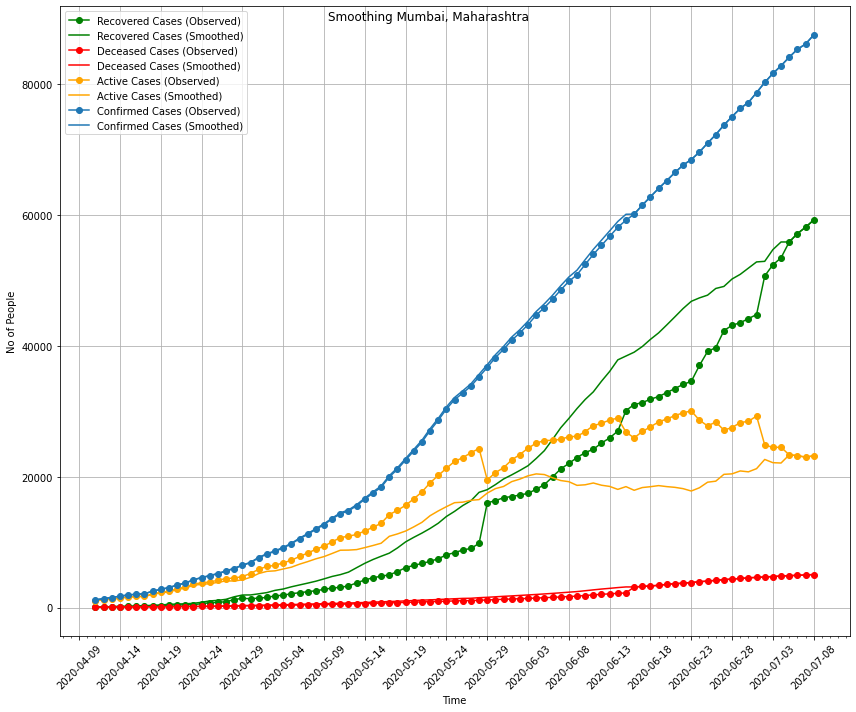

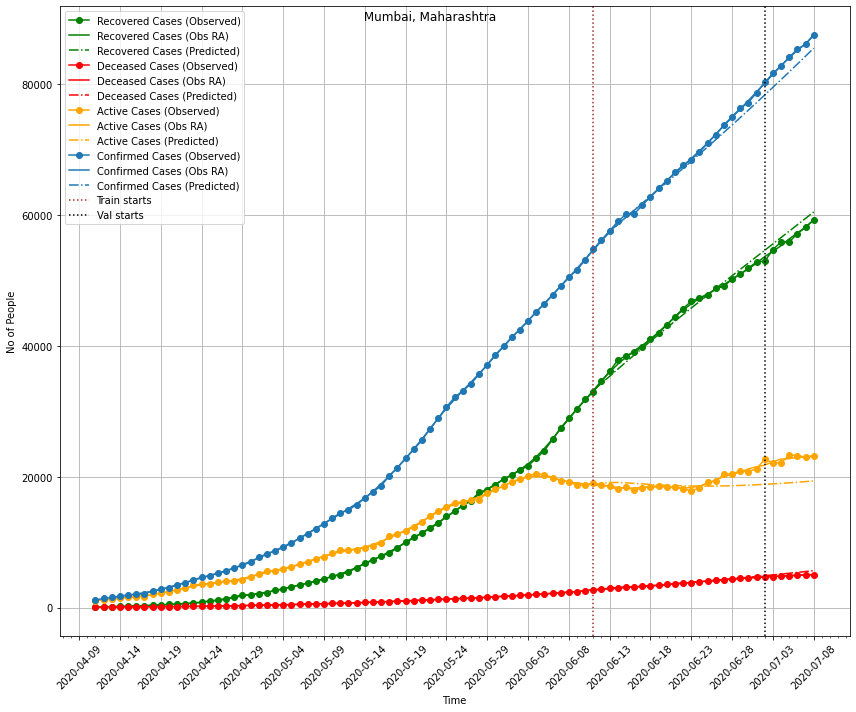

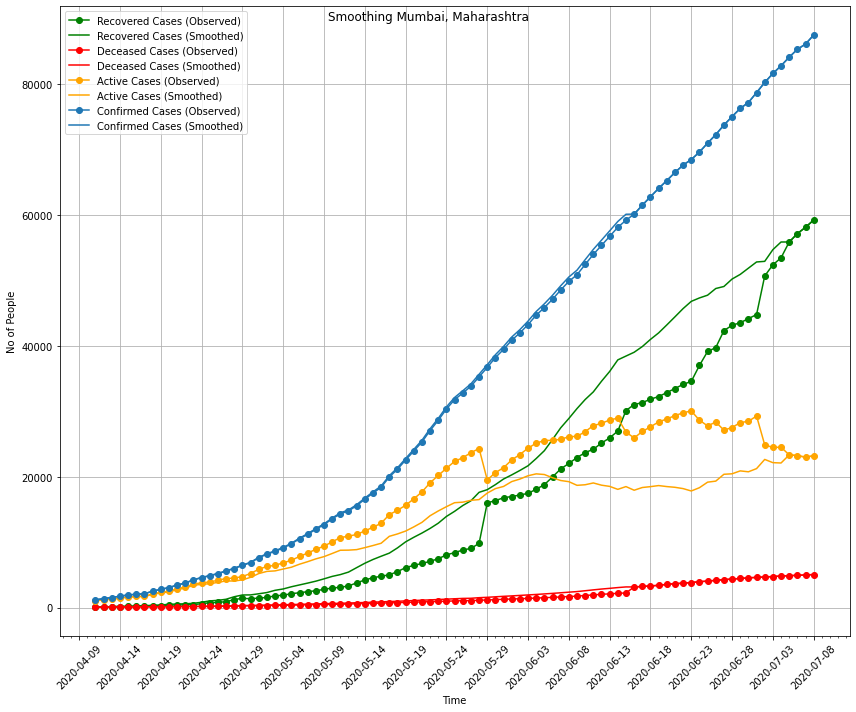

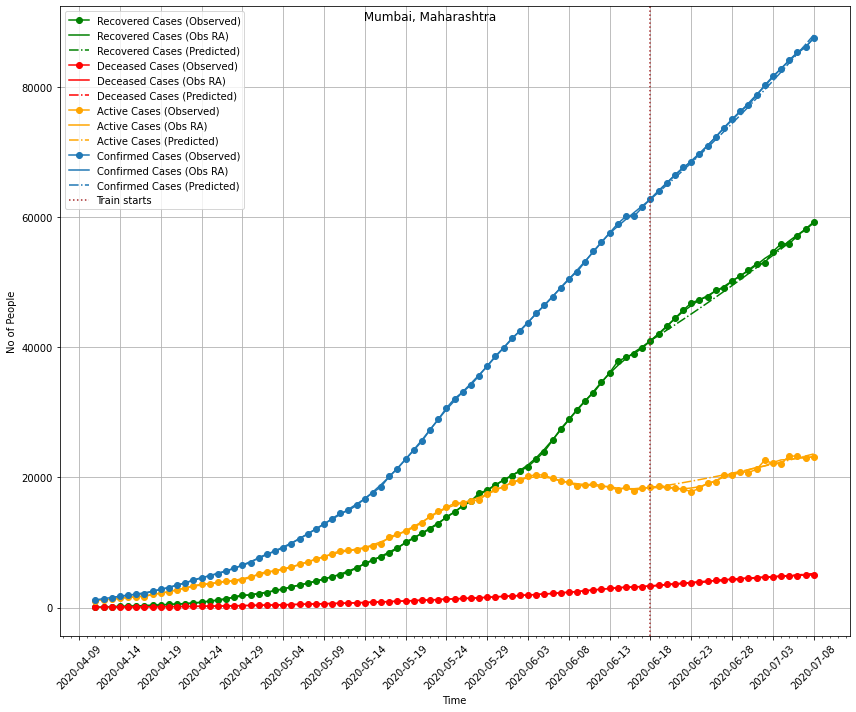

In [8]:
predictions_dict['m1'] = single_fitting_cycle(
    state, district, train_period=21, val_period=7, num_evals=1000,
    data_from_tracker=False, initialisation='intermediate', model=SEIRHD, 
    smooth_jump=True,
    which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
predictions_dict['m2'] = single_fitting_cycle(
    state, district, train_period=21, val_period=0, num_evals=1000,
    data_from_tracker=False, initialisation='intermediate', model=SEIRHD, 
    smooth_jump=True,
    which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

predictions_dict['state'] = state
predictions_dict['dist'] = district
predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
predictions_dict['datasource'] = 'covid19api' if predictions_dict['m1']['data_from_tracker'] else 'municipality'
predictions_dict['variable_param_ranges'] = predictions_dict['m1']['variable_param_ranges']
predictions_dict['data_last_date'] = predictions_dict['m2']['data_last_date']

## Fitting Loss

### M1 Loss

In [10]:
predictions_dict['m1']['df_loss']

,train,val
hospitalised,4.68273,19.4946
total_infected,0.820567,2.53898
deceased,1.1032,7.19526
recovered,1.3319,2.1934


### M2 Loss

In [11]:
predictions_dict['m2']['df_loss']

,train
hospitalised,2.41738
total_infected,0.531042
deceased,1.80401
recovered,1.31984


## Plot Forecasts

getting forecasts ..


11it [00:00, 101.73it/s]

getting forecasts ..


1000it [00:09, 100.78it/s]
13it [00:00, 127.25it/s]

getting forecasts ..


1000it [00:10, 97.41it/s]


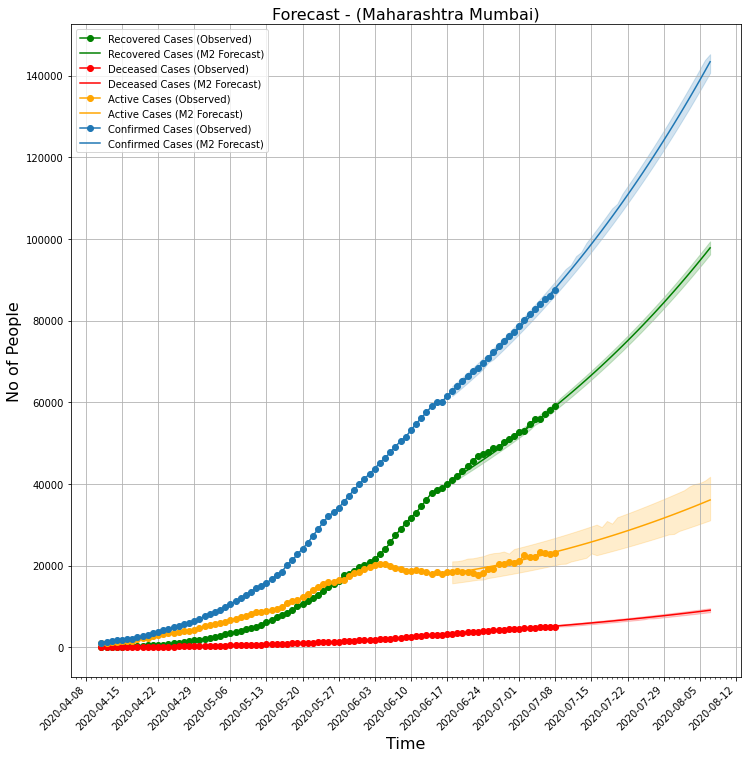

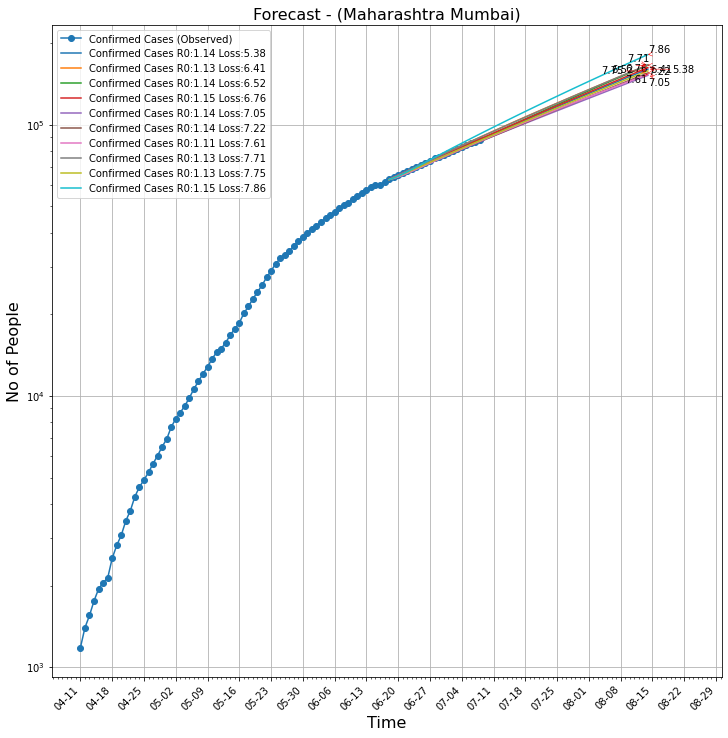

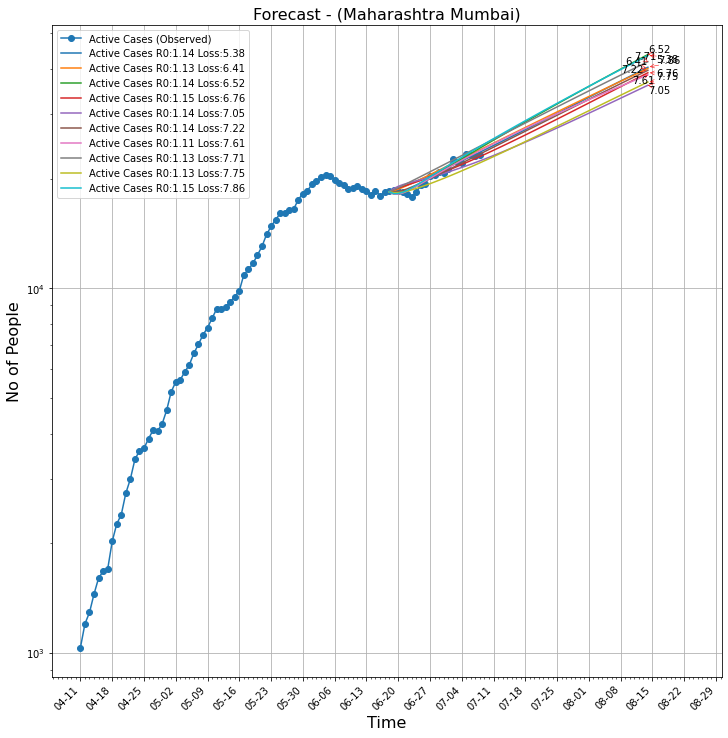

In [12]:
predictions_dict['m2']['forecast'] = plot_forecast(predictions_dict, (state, district), both_forecasts=False, error_bars=True)

trials_processed = forecast_all_trials(predictions_dict, train_fit='m1')
predictions_dict['m1']['trials_processed'] = trials_processed
predictions_dict['m1']['all_trials'] = trials_to_df(trials_processed)
trials_processed = forecast_all_trials(predictions_dict, train_fit='m2')
predictions_dict['m2']['trials_processed'] = trials_processed
predictions_dict['m2']['all_trials'] = trials_to_df(trials_processed)
kforecasts = plot_top_k_trials(
    predictions_dict,
    train_fit='m2',
    trials_processed=predictions_dict['m2']['trials_processed'], 
    k=ktrials,
    which_compartments=[Columns.confirmed, Columns.active])
predictions_dict['m2']['forecast_confirmed_topk'] = kforecasts[Columns.confirmed]
predictions_dict['m2']['forecast_active_topk'] = kforecasts[Columns.active]


## Create Report


In [13]:
create_report(predictions_dict, ROOT_DIR=output_folder)
predictions_dict['m1']['all_trials'].to_csv(os.path.join(output_folder, 'm1-trials.csv'))
predictions_dict['m2']['all_trials'].to_csv(os.path.join(output_folder, 'm2-trials.csv'))

## Create and Save Output CSV

In [14]:
df_output = create_region_csv(predictions_dict, district, 'district', days=forecast_days)

compiling csv data ..
getting forecasts ..


In [15]:
write_csv(df_output, filename=os.path.join(output_folder, f'output-{t}.csv'))